# 📚 Fine-Tuning with LoRA on Mac (MPS)
This notebook guides you step-by-step through the process of fine-tuning a language model using the LoRA (Low-Rank Adaptation) technique on Mac with MPS (Metal Performance Shaders) acceleration.

## 🎯 What is LoRA?
LoRA is an efficient technique for adapting pre-trained models that:

- Drastically reduces the parameters to be trained (from billions to a few million)
- Requires less GPU/RAM memory
- Allows you to maintain multiple versions of the model (only the adapters change)
- Produces results comparable to full fine-tuning

---

## 📦 Installing Libraries
Install all the Python packages needed for fine-tuning.

In [1]:
# Installing the necessary libraries
# Note: remove the ! if you are running from the terminal instead of Jupyter
%pip install transformers datasets peft accelerate trl torch

# (Optional) Verify versions)
# %pip show transformers peft torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 9.5 MB/s eta 0:00:00


## 📚 Library Import and MPS Verification
**What it does**: Imports all necessary libraries and verifies that Apple's MPS (Metal Performance Shaders) device is available and functioning.

**MPS**: Apple's hardware accelerator for Macs with M1/M2/M3 chips, equivalent to CUDA for NVIDIA.

⚠️ Recommendations:

If MPS is not available, training will use the CPU (much slower).
Make sure you have macOS 12.3+ and PyTorch 1.12+.
If you see “MPS available: False,” check your PyTorch version.

In [2]:
# ============================================
# LIBRARY IMPORT
# ============================================

import numpy as np
import torch
from transformers import (
    AutoModelForCausalLM,      # Class for causal models (GPT, Llama, etc.)
    AutoTokenizer,              # Automatic tokenizer
    TrainingArguments,          # Training configuration
    Trainer,                    # HuggingFace trainer class
    DataCollatorForLanguageModeling  # Prepares batches for language modeling
)
from peft import (
    LoraConfig,                 # LoRA configuration
    get_peft_model,             # Applies LoRA to the model
    TaskType                    # Task type (CAUSAL_LM, SEQ_2_SEQ, etc.)
)
from datasets import load_dataset  # Load dataset from HuggingFace Hub
import os

FINE_TUNED_MODEL_NAME = os.getenv("FINE_TUNED_MODEL_NAME", "")

# ============================================
# CHECK MPS DEVICE
# ============================================

print("=" * 50)
print("CHECK MPS DEVICE")
print("=" * 50)

# Check if MPS is available
mps_available = torch.backends.mps.is_available()
mps_built = torch.backends.mps.is_built()

print(f"✓ MPS available: {mps_available}")
print(f"✓ MPS built in PyTorch: {mps_built}")

# Select the best available device
if mps_available:
    device = torch.device("mps")
    print(f"✓ Selected device: MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print(f"⚠️  Selected device: CPU (training will be slower)")

print(f"✓ PyTorch version: {torch.__version__}")
print("=" * 50)

CHECK MPS DEVICE
✓ MPS available: False
✓ MPS built in PyTorch: False
⚠️  Selected device: CPU (training will be slower)
✓ PyTorch version: 2.9.0+cpu


## 🤖 Model and Tokenizer Loading
**What it does:** Loads the pre-trained language model and its tokenizer from HuggingFace Hub.

**Components:**

- **Tokenizer:** Converts text into numbers (token IDs) that the model can process.
- **Model:** The pre-trained neural network that will be fine-tuned.

**⚠️ Recommendations:**

- Start with small models (500M/1B parameters) for testing
- Larger models require more RAM
- For Llama or Mistral (7B parameters), you need at least 16GB of unified RAM
- torch.float16 halves memory usage compared to float32

In [7]:
# ============================================
# MODEL CONFIG
# ============================================

# Choose the model to fine-tune
model_name = "meta-llama/Llama-3.2-1B-Instruct"  # Example: "meta-llama/Llama-3.2-1B-Instruct"

print("=" * 50)
print(f"LOADING MODEL: {model_name}")
print("=" * 50)


# ============================================
# TOKENIZER LOADING
# ============================================

# The tokenizer converts text into token IDs and vice versa
tokenizer= AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True  # Allows custom code (necessary for some models)
)

# This is necessary for batching during training
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("✓ Pad token set to EOS token")

# ============================================
# MODEL LOADING
# ============================================

# Load the pre-trained model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,  # Use reduced precision to save memory
    device_map={"": device},     # Map the model to the selected device
    trust_remote_code=True       # Allows custom code
)

# ============================================
# MODEL INFORMATION
# ============================================

# Count the total parameters in the model
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Model loaded: {model_name}")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters (pre-LoRA): {trainable_params:,}")
print(f"✓ Vocabulary size: {len(tokenizer):,}")
print("=" * 50)

LOADING MODEL: meta-llama/Llama-3.2-1B-Instruct


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct.
401 Client Error. (Request ID: Root=1-69944205-157a45c17363ca9a4bd77580;412e99d9-a726-4872-838a-5d882ad8758b)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-1B-Instruct is restricted. You must have access to it and be authenticated to access it. Please log in.

### 🔍 Model Structure Inspection (Optional but Recommended)
**What it does**: Analyzes the internal structure of the model to identify which layers can be targeted by LoRA.

**Why it matters**: Each model architecture has different names for its layers. LoRA needs to know which layers to modify (typically the attention layers).

**⚠️ Recommendations**:

- Run this cell the first time you use a new model
- Helps understand the model structure
- Useful for debugging if LoRA cannot find the target modules

In [ ]:
# ============================================
# INSPECT MODEL STRUCTURE
# ============================================

print("=" * 50)
print("MODEL STRUCTURE ANALYSIS")
print("=" * 50)

# ============================================
# FIND LINEAR MODULES (CANDIDATES FOR LORA)
# ============================================

# LoRA works better on linear layers (fully connected)
# These are typically the attention and projection layers

print("\n📋 Linear modules found (candidates for LoRA):\n")

linear_modules = set()
for name, module in model.named_modules():
    # Find all linear layers
    if isinstance(module, torch.nn.Linear):
        # Extract the module name (last part of the path)
        module_name = name.split('.')[-1]
        linear_modules.add(module_name)

        # Show first 10 examples
        if len([m for m in model.named_modules() if m[0] == name]) <= 10:
            print(f"  • {name} → type: {type(module).__name__}")

# ============================================
# RELEVANT MODULES FOR LORA
# ============================================

print(f"\n✓ Linear modules found: {linear_modules}")
print("\n💡 These are the names to use in 'target_modules' for LoRA")

# Common modules to exclude (embedding and output layers)
exclude_modules = {'lm_head', 'embed_tokens', 'wte', 'wpe', 'ln_f'}
recommended_modules = linear_modules - exclude_modules

print(f"\n✅ Recommended modules for LoRA: {recommended_modules}")
print("\n" + "=" * 50)

MODEL STRUCTURE ANALYSIS

📋 Linear modules found (candidates for LoRA):

  • model.layers.0.self_attn.q_proj → type: Linear
  • model.layers.0.self_attn.k_proj → type: Linear
  • model.layers.0.self_attn.v_proj → type: Linear
  • model.layers.0.self_attn.o_proj → type: Linear
  • model.layers.0.mlp.gate_proj → type: Linear
  • model.layers.0.mlp.up_proj → type: Linear
  • model.layers.0.mlp.down_proj → type: Linear
  • model.layers.1.self_attn.q_proj → type: Linear
  • model.layers.1.self_attn.k_proj → type: Linear
  • model.layers.1.self_attn.v_proj → type: Linear
  • model.layers.1.self_attn.o_proj → type: Linear
  • model.layers.1.mlp.gate_proj → type: Linear
  • model.layers.1.mlp.up_proj → type: Linear
  • model.layers.1.mlp.down_proj → type: Linear
  • model.layers.2.self_attn.q_proj → type: Linear
  • model.layers.2.self_attn.k_proj → type: Linear
  • model.layers.2.self_attn.v_proj → type: Linear
  • model.layers.2.self_attn.o_proj → type: Linear
  • model.layers.2.mlp.gate_pro

## ⚙️ LoRA Configuration and Application
**What it does**: Configures LoRA parameters and applies adapters to the model. Only LoRA adapters will be trained, not the entire model.

**LoRA parameters explained**:

- `r (rank)`: Size of LoRA matrices. Typical values: 8-64. Higher = more capacity but more parameters
- `lora_alpha`: Scaling factor. Typically 2×r. Controls how much the adapters influence
- `target_modules`: Which layers to modify (attention, projections, etc.)
- `lora_dropout`: Dropout for regularization (0.05-0.1)
- `bias`: Whether to also train biases (“none”, ‘all’, “lora_only”)

**⚠️ Recommendations**:

- Start with r=8 or r=16 for quick tests
- r=32 or r=64 for better results but slower training
- If you have limited memory, reduce r
- For models from ~7B on unified 16 GB: start with r=8, alpha=16, and very small batches
- The automatic function finds the correct modules for any model

In [ ]:
# ============================================
#   FUNCTION TO FIND TARGET MODULES AUTOMATICALLY
# ============================================

def find_target_modules(model, exclude_names=None):
    """
    Identify candidate module names to apply LoRA to by scanning the model for
    linear layers.

    The function collects the last component of each module's dotted name
    (e.g. "transformer.h.0.attn.c_attn" -> "c_attn") and returns a list of
    unique module names, excluding common non-target modules like embeddings
    and the output head.

    Args:
        model: A torch.nn.Module (the loaded model) to inspect.
        exclude_names: Optional set of module names to exclude (strings).
                       If None, a sensible default set is used.

    Returns:
        A list of module names (strings) suitable for use as `target_modules`
        in a LoRA configuration.
    """
    if exclude_names is None:
        # Common modules to exclude (embedding layers and output head)
        exclude_names = {'lm_head', 'embed_tokens', 'wte', 'wpe', 'ln_f'}

    target_modules = set()

    # Find all linear layers in the model
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            # Extract the module name (last part of the path)
            # E.g. "transformer.h.0.attn.c_attn" → "c_attn"
            module_name = name.split('.')[-1]
            if module_name:  # skip empty root names
                target_modules.add(module_name)

    # Remove excluded names
    target_modules = target_modules - exclude_names

    return list(target_modules)

# ============================================
#   FUNCTION TO FIND TARGET MODULES AUTOMATICALLY
# ============================================

print("=" * 50)
print("LoRA CONFIGURATION")
print("=" * 50)

target_modules = find_target_modules(model)
print(f"\n✓ Target modules identified: {target_modules}")

LoRA CONFIGURATION

✓ Target modules identified: ['gate_proj', 'v_proj', 'down_proj', 'k_proj', 'o_proj', 'q_proj', 'up_proj']


In [ ]:
# ============================================
# LORA PARAMETERS CONFIGURATION
# ============================================

# Create LoRA configuration
lora_config = LoraConfig(
    # Rank of LoRA matrices (dimensionality of decomposition)
    # Typical values: 8 (fast), 16 (balanced), 32-64 (best results)
    r=16,

    # Alpha: scaling factor for LoRA adapters
    # General rule: alpha = 2 * r
    # Controls the intensity of the adaptation
    lora_alpha=32,

    # Modules to modify with LoRA
    # Typically attention and projection layers
    target_modules=target_modules,

    # Dropout for regularization (prevents overfitting)
    # Typical values: 0.05-0.1
    lora_dropout=0.05,

    # Whether to train biases as well
    # "none": do not train biases (more efficient)
    # "all": train all biases
    # "lora_only": train only LoRA layer biases
    bias="none",

    # Task type: CAUSAL_LM for autoregressive models (GPT, Llama)
    # Others: SEQ_2_SEQ_LM, SEQ_CLS, TOKEN_CLS, QUESTION_ANS
    task_type=TaskType.CAUSAL_LM
)

print(f"\n📊 LoRA Configuration :")
print(f"  • Rank (r): {lora_config.r}")
print(f"  • Alpha: {lora_config.lora_alpha}")
print(f"  • Dropout: {lora_config.lora_dropout}")
print(f"  • Target modules: {lora_config.target_modules}")
print(f"  • Task type: {lora_config.task_type}")

# ============================================
# APPLY LORA TO MODEL
# ============================================

# Wrap the base model with LoRA adapters
# Only the adapters will be trained, the rest remains frozen

model = get_peft_model(model, lora_config)

# ============================================
# ENABLE MEMORY SAVING TECHNIQUES
# ============================================

# Use getattr/setattr to avoid Pylance errors
# Gradient checkpointing: reduces peak memory during training
gradient_checkpointing_fn = getattr(model, "gradient_checkpointing_enable", None)
if gradient_checkpointing_fn is not None and callable(gradient_checkpointing_fn):
    gradient_checkpointing_fn()
    print("✓ Gradient checkpointing enabled")

# Enable input require grads: necessary for gradient checkpointing with LoRA
enable_grads_fn = getattr(model, "enable_input_require_grads", None)
if enable_grads_fn is not None and callable(enable_grads_fn):
    enable_grads_fn()
    print("✓ Input require grads enabled")

# Disable cache to save memory during training
if hasattr(model, "config") and hasattr(model.config, "use_cache"):
    setattr(model.config, "use_cache", False)
    print("✓ Cache disabled")

# ============================================
# PARAMETER STATISTICS
# ============================================

print("\n" + "=" * 50)
print("PARAMETER STATISTICS")
print("=" * 50)
model.print_trainable_parameters()
print("=" * 50)

# Reduction is typically 99%+
# E.g. from 124M parameters to ~300K trainable parameters


📊 LoRA Configuration :
  • Rank (r): 16
  • Alpha: 32
  • Dropout: 0.05
  • Target modules: {'gate_proj', 'v_proj', 'down_proj', 'up_proj', 'k_proj', 'q_proj', 'o_proj'}
  • Task type: CAUSAL_LM
'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/matteo/Desktop/rnd/lora/venv/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


✓ Gradient checkpointing enabled
✓ Input require grads enabled
✓ Cache disabled

PARAMETER STATISTICS
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039


## 📊 Dataset Preparation
**What it does**: Loads a dataset, tokenizes it (converts text into numbers), and splits it into training and validation sets.

**Process**:

1. Load the dataset from HuggingFace Hub
2. Tokenize the text (convert to token IDs)
3. Apply padding and truncation to standardize lengths
4. Divide into train/validation split

⚠️ **Recommendations**:

- For quick tests, use a small subset (e.g., `split=“train[:1000]”`)
- `max_length=512` is a good compromise. Higher values require more memory
- For your custom dataset, replace `load_dataset` with your own data loading
- Make sure the dataset has a “text” column or adapt the tokenization function

Recommended datasets for initial testing:

- `imdb`: Movie reviews (sentiment analysis), used in this notebook
- `wikitext`: Text from Wikipedia
- `openwebtext`: Text from the web
- Your custom dataset in CSV/JSON format

In [ ]:
# ============================================
# LOAD DATASET
# ============================================

from typing import cast
from datasets import Dataset  # Import for type hint

print("=" * 50)
print("DATASET PREPARATION")
print("=" * 50)

# Load a sample dataset from HuggingFace Hub
# IMDB contains movie reviews (positive/negative)
# For quick tests, we only use 1000 examples
dataset = cast(
    Dataset,
    load_dataset(
        "imdb",
        split="train[:1000]"
    )
)

print(f"\n✓ Dataset loaded: IMDB")
print(f"✓ Number of examples: {len(dataset)}")
print(f"✓ Available columns: {dataset.column_names}")

# Show an example
print(f"\n📝 Example text:")
example_text = dataset[0]["text"]  # Explicit access, more type-safe
if isinstance(example_text, str):
    print(f"{example_text[:200]}...")

# ============================================
# TOKENIZATION FUNCTION
# ============================================

def tokenize_function(examples):
    """
    Tokenizes the dataset text.

    Args:
        examples: Batch of examples from the dataset

    Returns:
        Dict with input_ids, attention_mask, etc.
    """
    return tokenizer(
        examples["text"],        # Column containing the text
        truncation=True,         # Truncate texts longer than max_length
        max_length=512,          # Maximum length in tokens
        padding="max_length",    # Pad all examples to max_length
        return_tensors=None      # Return lists, not tensors (for now)
    )

# ============================================
# DATASET TOKENIZATION
# ============================================

print(f"\n🔄 Tokenization in progress...")

# Apply tokenization to the entire dataset
# batched=True processes multiple examples at once (faster)
tokenized_dataset: Dataset = dataset.map(  # Type hint for Pylance
    tokenize_function,           # Function to apply
    batched=True,                # Process in batch (more efficient)
    remove_columns=list(dataset.column_names),  # Explicit cast to list
    desc="Tokenizing dataset"    # Description for progress bar
)

print(f"✓ Tokenization completed")

# ============================================
# TRAIN/VALIDATION SPLIT
# ============================================

# Split the dataset into training and validation
# The validation set is used to monitor overfitting
train_test_split = tokenized_dataset.train_test_split(
    test_size=0.1,    # 10% for validation, 90% for training
    seed=42           # Seed for reproducibility
)

train_dataset: Dataset = train_test_split["train"]  # Explicit type hint
eval_dataset: Dataset = train_test_split["test"]    # Explicit type hint

print(f"\n✓ Split completed:")
print(f"  • Training samples: {len(train_dataset)}")
print(f"  • Validation samples: {len(eval_dataset)}")

# ============================================
# TOKENIZATION INFORMATION
# ============================================

print(f"\n📊 Tokenization statistics:")
print(f"  • Max length: 512 tokens")
print(f"  • Padding: max_length")
print(f"  • Truncation: enabled")

# Show a tokenized example
print(f"\n🔢 Tokenization example:")
print(f"  • Input IDs shape: {len(train_dataset[0]['input_ids'])}")
print(f"  • First 10 token IDs: {train_dataset[0]['input_ids'][:10]}")

print("=" * 50)

DATASET PREPARATION

✓ Dataset loaded: IMDB
✓ Number of examples: 1000
✓ Available columns: ['text', 'label']

📝 Example text:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...

🔄 Tokenization in progress...


Tokenizing dataset: 100%|██████████| 1000/1000 [00:00<00:00, 6088.09 examples/s]

✓ Tokenization completed

✓ Split completed:
  • Training samples: 900
  • Validation samples: 100

📊 Tokenization statistics:
  • Max length: 512 tokens
  • Padding: max_length
  • Truncation: enabled

🔢 Tokenization example:
  • Input IDs shape: 512
  • First 10 token IDs: [128000, 1, 21119, 426, 1, 374, 26549, 555, 10826, 32294]


## 🎯 Training Configuration
**What it does**: Configures all parameters for training: batch size, learning rate, number of epochs, saving strategies, logging, etc.

**Key parameters explained**:

**Batch Size and Gradient Accumulation**:

- `per_device_train_batch_size`: How many examples to process together (higher = faster but more memory)
- `gradient_accumulation_steps`: Accumulates gradients for N steps before updating weights (simulates larger batch sizes)
- Effective batch size = `per_device_train_batch_size` × `gradient_accumulation_steps`

**Learning Rate**:

- `learning_rate`: How fast the model learns (2e-4 is a good default for LoRA)
- Too high: unstable training
- Too low: very slow training

**Strategies**:

- `evaluation_strategy`: When to evaluate the model (“steps”, ‘epoch’, “no”)
- `save_strategy`: When to save checkpoints (“steps”, ‘epoch’, “no”)

⚠️ **Recommendations**:

- If you have memory issues, reduce `per_device_train_batch_size` to 1 or 2\
- Increase `gradient_accumulation_steps` to compensate for small batch sizes
- `num_train_epochs=3` is a good starting point
- Monitor the loss: if it doesn't decrease, increase the learning rate or epochs
- Enable gradient checkpointing when working with models >3B: it consumes less memory but increases the time per step
- For a 7B model on a Mac with 16 GB: use `per_device_train_batch_size=1`, `gradient_accumulation_steps=8`, `max_length=384`, `r=8`, `lora_alpha=16`

In [ ]:
# ============================================
# DATA COLLATOR
# ============================================

# The data collator prepares batches during training
# For language modeling, it automatically handles labels
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # False = Causal LM (predicts next token)
               # True = Masked LM (predicts masked tokens, for BERT)
)

print("=" * 50)
print("TRAINING CONFIGURATION")
print("=" * 50)

# ============================================
# TRAINING ARGUMENTS
# ============================================

training_args = TrainingArguments(
    # ----------------------------------------
    # PATHS AND OUTPUT
    # ----------------------------------------
    output_dir=f"./{FINE_TUNED_MODEL_NAME}-finetuned",      # Where to save checkpoints       # Where to save TensorBoard logs

    # ----------------------------------------
    # TRAINING DURATION
    # ----------------------------------------
    num_train_epochs=3,                  # Number of epochs (full passes over the dataset)
                                         # 3-5 epochs are typically enough for LoRA

    # ----------------------------------------
    # BATCH SIZE AND GRADIENT ACCUMULATION
    # ----------------------------------------
    per_device_train_batch_size=4,       # Batch size per device during training
                                         # Reduce to 2 or 1 if you have memory issues

    per_device_eval_batch_size=4,        # Batch size per device during evaluation
                                         # Can be higher than train batch size

    gradient_accumulation_steps=4,       # Accumulate gradients for N steps
                                         # Effective batch size = 4 × 4 = 16
                                         # Useful to simulate large batch sizes

    # ----------------------------------------
    # LEARNING RATE AND OPTIMIZATION
    # ----------------------------------------
    learning_rate=2e-4,                  # Learning rate (2e-4 is standard for LoRA)
                                         # Typical range: 1e-5 to 5e-4

    warmup_steps=100,                    # Warmup steps (gradually increase LR)
                                         # Helps stability at the start of training

    # ----------------------------------------
    # MEMORY SAVING TECHNIQUES
    # ----------------------------------------
    gradient_checkpointing=True,         # Save memory by trading off with compute time

    # ----------------------------------------
    # PRECISION AND DEVICE
    # ----------------------------------------
    fp16=False,                          # Do not use mixed precision float16
                                         # MPS does not natively support fp16

    bf16=False,                          # Do not use bfloat16
                                         # MPS does not support bf16

    # ----------------------------------------
    # LOGGING AND MONITORING
    # ----------------------------------------
    logging_steps=10,                    # Log metrics every N steps
                                         # Lower = more detailed but slower

    report_to="none",                    # Where to send logs
                                         # "none": nowhere
                                         # "tensorboard": TensorBoard
                                         # "wandb": Weights & Biases

    # ----------------------------------------
    # EVALUATION
    # ----------------------------------------
    eval_strategy="steps",               # When to evaluate: "steps", "epoch", "no"
    eval_steps=100,                      # Evaluate every 100 steps
                                         # Useful to monitor overfitting

    # ----------------------------------------
    # CHECKPOINT SAVING
    # ----------------------------------------
    save_strategy="steps",               # When to save: "steps", "epoch", "no"
    save_steps=100,                      # Save checkpoint every 100 steps
    save_total_limit=3,                  # Keep only the last 3 checkpoints
                                         # Saves disk space

    load_best_model_at_end=True,         # Load the best model at the end
                                         # Based on eval_loss

    # ----------------------------------------
    # OTHER OPTIONS
    # ----------------------------------------
    remove_unused_columns=False,         # Do not remove extra columns from the dataset

    # Optional: seed for reproducibility
    seed=42,
)

# ============================================
# CONFIGURATION SUMMARY
# ============================================

print(f"\n📊 Configuration summary:")
print(f"\n  Training:")
print(f"    • Epochs: {training_args.num_train_epochs}")
print(f"    • Batch size (per device): {training_args.per_device_train_batch_size}")
print(f"    • Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"    • Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"    • Learning rate: {training_args.learning_rate}")
print(f"    • Warmup steps: {training_args.warmup_steps}")

print(f"\n  Evaluation:")
print(f"    • Strategy: {training_args.eval_strategy}")
print(f"    • Every: {training_args.eval_steps} steps")

print(f"\n  Saving:")
print(f"    • Strategy: {training_args.save_strategy}")
print(f"    • Every: {training_args.save_steps} steps")
print(f"    • Total checkpoints: {training_args.save_total_limit}")

print(f"\n  Device:")
print(f"    • FP16: {training_args.fp16}")
print(f"\n  Memory:")
print(f"    • Gradient checkpointing: {training_args.gradient_checkpointing}")

# Calculate total steps
steps_per_epoch = len(train_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
total_steps = steps_per_epoch * training_args.num_train_epochs

print(f"\n  Estimated duration:")
print(f"    • Steps per epoch: ~{steps_per_epoch}")
print(f"    • Total steps: ~{total_steps}")

print("\n✓ Training configuration completed")
print("=" * 50)

TRAINING CONFIGURATION

📊 Configuration summary:

  Training:
    • Epochs: 3
    • Batch size (per device): 4
    • Gradient accumulation: 4
    • Effective batch size: 16
    • Learning rate: 0.0002
    • Warmup steps: 100

  Evaluation:
    • Strategy: steps
    • Every: 100 steps

  Saving:
    • Strategy: steps
    • Every: 100 steps
    • Total checkpoints: 3

  Device:
    • FP16: False

  Memory:
    • Gradient checkpointing: True

  Estimated duration:
    • Steps per epoch: ~56
    • Total steps: ~168

✓ Training configuration completed


## 🚀 Model Training
**What it does**: Initializes the HuggingFace Trainer and starts the fine-tuning process. This is the cell that actually performs the training.

**What happens during training**:

1. The model processes batches of data
2. Calculates the loss (prediction error)
3. Calculates gradients via backpropagation
4. Updates only the LoRA parameters (not the entire model)
5. Periodically evaluates on the validation set
6. Saves checkpoints

⚠️ **Recommendations**:

- Training can take from minutes to hours (depending on the dataset and hardware)
- Monitor the loss: it should decrease gradually
- If the training loss decreases but the evaluation loss increases = overfitting
- You can stop with the stop button and resume from the checkpoint
- The first epoch is slower (MPS compilation)

**Metrics to monitor:**

- `loss`: Error on the training set (should decrease)
- `eval_loss`: Error on the validation set (should decrease, but not too much compared to loss)
- `learning_rate`: Changes during warmup

In [ ]:
# ============================================
# TRAINER INITIALIZATION
# ============================================

print("=" * 50)
print("TRAINER INITIALIZATION")
print("=" * 50)

# The Trainer is the HuggingFace class that handles the entire training loop
trainer = Trainer(
    model=model,                    # The model with LoRA applied
    args=training_args,             # Training configuration
    train_dataset=train_dataset,    # Training dataset
    eval_dataset=eval_dataset,      # Validation dataset
    data_collator=data_collator,    # Prepares batches
)

print("✓ Trainer initialized")
print(f"✓ Model: {model_name}")
print(f"✓ Training samples: {len(train_dataset)}")
print(f"✓ Validation samples: {len(eval_dataset)}")

# ============================================
# START TRAINING
# ============================================

print("\n" + "=" * 50)
print("🚀 START TRAINING")
print("=" * 50)
print("\n⏳ Training has started...")
print("💡 Monitor the metrics below:")
print("   • loss: error on the training set (should decrease)")
print("   • eval_loss: error on the validation set")
print("   • learning_rate: current learning rate")
print("\n" + "=" * 50 + "\n")

# Start training
# This may take several minutes/hours
train_result = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.


TRAINER INITIALIZATION
✓ Trainer initialized
✓ Model: meta-llama/Llama-3.2-1B-Instruct
✓ Training samples: 900
✓ Validation samples: 100

🚀 START TRAINING

⏳ Training has started...
💡 Monitor the metrics below:
   • loss: error on the training set (should decrease)
   • eval_loss: error on the validation set
   • learning_rate: current learning rate




/Users/matteo/Desktop/rnd/lora/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss
100,3.212300,3.258708


/Users/matteo/Desktop/rnd/lora/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
# ============================================
# TRAINING COMPLETED
# ============================================

print("\n" + "=" * 50)
print("✅ TRAINING COMPLETED!")
print("=" * 50)

# Show final training statistics
print(f"\n📊 Final training statistics:")
print(f"  • Training loss: {train_result.training_loss:.4f}")
print(f"  • Training steps: {train_result.global_step}")
print(f"  • Total time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  • Samples/second: {train_result.metrics['train_samples_per_second']:.2f}")

# ============================================
# FINAL EVALUATION
# ============================================

print(f"\n🔍 Final evaluation on the validation set...")
eval_results = trainer.evaluate()

print(f"\n📈 Validation results:")
print(f"  • Eval loss: {eval_results['eval_loss']:.4f}")
print(f"  • Perplexity: {np.exp(eval_results['eval_loss']):.2f}")

# Perplexity: Measure of how "confused" the model is
# Lower = better. Typical values: 10-50 for small models

print("=" * 50)


✅ TRAINING COMPLETED!

📊 Final training statistics:
  • Training loss: 3.1574
  • Training steps: 171
  • Total time: 2814.69 seconds
  • Samples/second: 0.96

🔍 Final evaluation on the validation set...


/Users/matteo/Desktop/rnd/lora/venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



📈 Validation results:
  • Eval loss: 3.2587
  • Perplexity: 26.02


## 💾 Model Saving
**What it does**: Saves the fine-tuned model (LoRA adapters only) and tokenizer to disk.

⚠️ **Recommendations**:

- LoRA adapters are very lightweight (a few MB vs. GB for the full model)
- You can save multiple versions with different names
- To share the model, you also need the original base model
- Important backup: save to the cloud or an external drive

In [ ]:
# ============================================
# SAVE FINE-TUNED MODEL
# ============================================

print("=" * 50)
print("MODEL SAVING")
print("=" * 50)

# Path to save the model
output_dir = f"./{FINE_TUNED_MODEL_NAME}-finetuned"

print(f"\n💾 Saving in progress...")
print(f"📁 Path: {output_dir}")

# ============================================
# SAVE LORA ADAPTER
# ============================================

# Save only the LoRA adapters (few MB)
# The base model is not saved (saves space)
model.save_pretrained(output_dir)
print(f"✓ LoRA adapters saved")

# ============================================
# SAVE TOKENIZER
# ============================================

# Also save the tokenizer (needed for inference)
tokenizer.save_pretrained(output_dir)
print(f"✓ Tokenizer saved")

# ============================================
# SAVED FILE INFORMATION
# ============================================

import os

print(f"\n📂 Saved files:")
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"  • {file} ({size_mb:.2f} MB)")

# Calculate total size
total_size = sum(
    os.path.getsize(os.path.join(output_dir, f))
    for f in os.listdir(output_dir)
) / (1024 * 1024)

print(f"\n✓ Total size: {total_size:.2f} MB")
print(f"\n💡 Note: Only LoRA adapters are saved (~{total_size:.0f} MB)")
print(f"   The base model ({model_name}) must be loaded separately")

print("\n" + "=" * 50)
print("✅ SAVING COMPLETED")
print("=" * 50)

# ============================================
# INSTRUCTIONS TO LOAD THE MODEL
# ============================================

print(f"\n📖 To load this model in the future:")
print(f"""
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load base model
base_model = AutoModelForCausalLM.from_pretrained("{model_name}")

# Load LoRA adapter
model = PeftModel.from_pretrained(base_model, "{output_dir}")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("{output_dir}")
""")

MODEL SAVING

💾 Saving in progress...
📁 Path: ./lora-finetuned-imdb-finetuned
✓ LoRA adapters saved
✓ Tokenizer saved

📂 Saved files:
  • adapter_model.safetensors (43.03 MB)
  • tokenizer_config.json (0.05 MB)
  • special_tokens_map.json (0.00 MB)
  • checkpoint-100 (0.00 MB)
  • checkpoint-171 (0.00 MB)
  • tokenizer.json (16.41 MB)
  • README.md (0.00 MB)
  • adapter_config.json (0.00 MB)
  • chat_template.jinja (0.00 MB)

✓ Total size: 59.50 MB

💡 Note: Only LoRA adapters are saved (~60 MB)
   The base model (meta-llama/Llama-3.2-1B-Instruct) must be loaded separately

✅ SAVING COMPLETED

📖 To load this model in the future:

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load base model
base_model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

# Load LoRA adapter
model = PeftModel.from_pretrained(base_model, "./lora-finetuned-imdb-finetuned")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("./lora-

## 🧪 Model Testing and Inference
**What it does**: Loads the fine-tuned model and generates text to test the training results.

**Generation parameters**:

- `max_new_tokens`: How many new tokens to generate
- `temperature`: Randomness *(0.1 = conservative, 1.0 = creative, 2.0 = very random)*
- `top_p`: Nucleus sampling *(0.9 = use top 90% probability)*
- `top_k`: Consider only the top K most probable tokens
- `do_sample`: True = probabilistic sampling, False = greedy (always the most probable)

⚠️ Recommendations:

- Test with various prompts to evaluate the model
- Compare with the base model (without LoRA) to see the improvement
- Experiment with different temperatures for different results
  - Low temperature *(0.3-0.7)* = more consistent
  - High temperature *(0.8-1.2)* = more creative

In [ ]:
# ============================================
# LOAD MODEL FOR INFERENCE
# ============================================

print("=" * 50)
print("FINE-TUNED MODEL TEST")
print("=" * 50)

from peft import PeftModel
from typing import cast

print(f"\n🔄 Loading model...")

# ============================================
# LOAD BASE MODEL
# ============================================

# Reload the base model (without LoRA)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map={"": device},
    trust_remote_code=True
)

print(f"✓ Base model loaded: {model_name}")

# ============================================
# LOAD LORA ADAPTER
# ============================================

# Load the fine-tuned LoRA adapters
model = PeftModel.from_pretrained(base_model, output_dir)
model.eval()  # Set to evaluation mode (disable dropout)

# Cast for type checking - model is PeftModel which has base_model
peft_model = cast(PeftModel, model)
if hasattr(peft_model, 'base_model') and hasattr(peft_model.base_model, 'config'):
    peft_model.base_model.config.use_cache = True  # type: ignore[attr-defined]

print(f"✓ LoRA adapters loaded from: {output_dir}")

# ============================================
# LOAD TOKENIZER
# ============================================

tokenizer = AutoTokenizer.from_pretrained(output_dir)
print(f"✓ Tokenizer loaded")

# ============================================
# GENERATION FUNCTION
# ============================================

def generate_text(prompt: str, max_new_tokens: int = 100, temperature: float = 0.7,
                  top_p: float = 0.9, top_k: int = 50) -> str:
    """
    Generate text from a prompt.

    Args:
        prompt: Initial text
        max_new_tokens: Maximum number of tokens to generate
        temperature: Controls randomness (0.1-2.0)
        top_p: Nucleus sampling (0.0-1.0)
        top_k: Top-k sampling

    Returns:
        Generated text
    """
    # Tokenize the prompt and move directly to device
    encoded = tokenizer(prompt, return_tensors="pt")
    input_ids = cast(torch.Tensor, encoded["input_ids"]).to(device)
    attention_mask = cast(torch.Tensor, encoded["attention_mask"]).to(device)

    # Generate
    with torch.no_grad():  # Disable gradient calculation (faster)
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True,           # Use sampling (not greedy)
            top_p=top_p,              # Nucleus sampling
            top_k=top_k,              # Top-k sampling
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1,   # Penalize repetitions
        )

    # Decode output
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return generated_text

# ============================================
# TEST WITH VARIOUS PROMPTS
# ============================================

print("\n" + "=" * 50)
print("🧪 GENERATION EXAMPLES")
print("=" * 50)

# List of test prompts
test_prompts = [
    "This movie was absolutely",
    "I really enjoyed",
    "The plot was",
    "The acting performance",
]

for i, prompt in enumerate(test_prompts, 1):
    print(f"\n--- Example {i} ---")
    print(f"📝 Prompt: '{prompt}'")

    # Generate text
    generated = generate_text(
        prompt,
        max_new_tokens=50,
        temperature=0.7
    )

    # Extract only the generated part (remove the prompt)
    generated_only = generated[len(prompt):].strip()

    print(f"🤖 Generated: '{generated_only}'")
    print(f"📄 Complete: '{generated}'")

# ============================================
# INTERACTIVE TEST
# ============================================

print("\n" + "=" * 50)
print("💬 INTERACTIVE TEST")
print("=" * 50)
print("\n💡 Try your own custom prompts!")
print("   Edit the variable 'custom_prompt' below:\n")

# Edit this prompt with your own text
custom_prompt = "This film is a masterpiece because"

print(f"📝 Custom prompt: '{custom_prompt}'")

# Generate with customizable parameters
generated = generate_text(
    custom_prompt,
    max_new_tokens=100,      # Generate up to 100 tokens
    temperature=0.7,         # Balanced between coherence and creativity
    top_p=0.9,              # Nucleus sampling
    top_k=50                # Top-k sampling
)

print(f"\n🤖 Generated text:")
print(f"{generated}")

# ============================================
# COMPARISON WITH BASE MODEL (OPTIONAL)
# ============================================

print("\n" + "=" * 50)
print("🔬 COMPARISON: Fine-tuned vs Base")
print("=" * 50)

# Load base model without LoRA for comparison
base_model_only = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map={"": device}
)
base_model_only.eval()

comparison_prompt = "This movie was"

print(f"\n📝 Prompt: '{comparison_prompt}'")

# Generate with base model - with explicit casts
encoded_base = tokenizer(comparison_prompt, return_tensors="pt")
input_ids_base = cast(torch.Tensor, encoded_base["input_ids"]).to(device)
attention_mask_base = cast(torch.Tensor, encoded_base["attention_mask"]).to(device)

with torch.no_grad():
    base_output = base_model_only.generate(
        input_ids=input_ids_base,
        attention_mask=attention_mask_base,
        max_new_tokens=50,
        temperature=0.7,
        do_sample=True,
        top_p=0.9
    )
base_text = tokenizer.decode(base_output[0], skip_special_tokens=True)

# Generate with fine-tuned model
finetuned_text = generate_text(comparison_prompt, max_new_tokens=50)

print(f"\n🔵 BASE MODEL:")
print(f"{base_text}")

print(f"\n🟢 FINE-TUNED MODEL:")
print(f"{finetuned_text}")

print("\n💡 Notice the differences in style and content!")

print("\n" + "=" * 50)

FINE-TUNED MODEL TEST

🔄 Loading model...


`torch_dtype` is deprecated! Use `dtype` instead!


✓ Base model loaded: meta-llama/Llama-3.2-1B-Instruct
✓ LoRA adapters loaded from: ./lora-finetuned-imdb-finetuned
✓ Tokenizer loaded

🧪 GENERATION EXAMPLES

--- Example 1 ---
📝 Prompt: 'This movie was absolutely'
🤖 Generated: 'terrible. I can't believe the people who made this were so dumb they thought it would be funny to make a movie about a guy who falls in love with his boss's wife.<br /><br />I have seen better movies than this one.'
📄 Complete: 'This movie was absolutely terrible. I can't believe the people who made this were so dumb they thought it would be funny to make a movie about a guy who falls in love with his boss's wife.<br /><br />I have seen better movies than this one.'

--- Example 2 ---
📝 Prompt: 'I really enjoyed'
🤖 Generated: 'this movie. The plot was very interesting, and the acting wasn't bad at all. I liked how they kept it real throughout the whole movie (no one seems to be a complete fake). It's not like any other movie ever made that is'
📄 Complete: 'I rea

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Prompt: 'This movie was'

🔵 BASE MODEL:
This movie was released in 1995, but it has gained popularity in recent years. It is a science fiction film directed by Robert Zemeckis, starring Tom Hanks and Meg Ryan. The movie is set in a dystopian future where a global pandemic

🟢 FINE-TUNED MODEL:
This movie was so bad, I could not stand to watch it again. The special effects were awful and the plot just seemed like a bunch of garbage thrown together. There is no way this movie should have been rated for adult content! It's really funny how much

💡 Notice the differences in style and content!



## 🔗 Merge Adapters (Optional)
**What it does**: Combines LoRA adapters with the base model to create a complete standalone model.

**When to use merge**:

- ✅ For production deployment (faster)
- ✅ To share the complete model
- ✅ If you don't need to switch between different adapters

**When NOT to use merge**:

- ❌ If you want to keep multiple LoRA versions for the same base model
- ❌ If disk space is limited (merging creates a complete model)
- ❌ If you want to continue fine-tuning

⚠️ **Recommendations**:

- The merged model is larger (size of the complete base model)
- Inference is slightly faster (no LoRA overhead)
- You can no longer edit only the adapters after merging

In [ ]:
# ============================================
# MERGE LORA ADAPTER WITH BASE MODEL
# ============================================

from typing import cast
import os

print("=" * 50)
print("MERGE LORA ADAPTER")
print("=" * 50)

print(f"\n🔄 Merging in progress...")
print(f"💡 This combines the LoRA adapters with the base model")

# ============================================
# EXECUTE MERGE
# ============================================

# Merge: combines LoRA weights with base model weights
# Result: a complete model without separate adapters
merged_model = model.merge_and_unload() # type: ignore[attr-defined]

print(f"✓ Merge completed")

# ============================================
# SAVE MERGED MODEL
# ============================================

merged_output_dir = f"./{FINE_TUNED_MODEL_NAME}-merged"

print(f"\n💾 Saving merged model...")
print(f"📁 Path: {merged_output_dir}")

# Save the merged model (full size)
merged_model.save_pretrained(merged_output_dir)
tokenizer.save_pretrained(merged_output_dir)

print(f"✓ Merged model saved")

# ============================================
# SIZE COMPARISON
# ============================================

def get_dir_size(path: str) -> float:
    """Calculate total size of a directory"""
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total += os.path.getsize(filepath)
    return total / (1024 * 1024)  # Convert to MB

adapter_size = get_dir_size(output_dir)
merged_size = get_dir_size(merged_output_dir)

print(f"\n📊 Size comparison:")
print(f"  • LoRA Adapter: {adapter_size:.2f} MB")
print(f"  • Merged Model: {merged_size:.2f} MB")
print(f"  • Difference: {merged_size - adapter_size:.2f} MB")

# ============================================
# ADVANTAGES AND DISADVANTAGES
# ============================================

print(f"\n" + "=" * 50)
print("ADAPTER vs MERGED")
print("=" * 50)

print(f"\n✅ Advantages of ADAPTER (not merged):")
print(f"  • Smaller size (~{adapter_size:.0f} MB)")
print(f"  • You can have multiple adapters for the same base model")
print(f"  • Easy to share and version")

print(f"\n✅ Advantages of MERGED:")
print(f"  • Slightly faster inference")
print(f"  • Easier to deploy (single model)")
print(f"  • No need to load base model + adapter")

print(f"\n💡 Recommendation:")
print(f"  • Use ADAPTER for development and experimentation")
print(f"  • Use MERGED for production deployment")

# ============================================
# TEST MERGED MODEL
# ============================================

print(f"\n" + "=" * 50)
print("TEST MERGED MODEL")
print("=" * 50)

# Load the merged model for testing
merged_model_test = AutoModelForCausalLM.from_pretrained(
    merged_output_dir,
    torch_dtype=torch.float16,
    device_map={"": device}
)
merged_model_test.eval()

test_prompt = "This movie was absolutely"

# Tokenize and move to device - CORRECT with cast
encoded_test = tokenizer(test_prompt, return_tensors="pt")
input_ids_test = cast(torch.Tensor, encoded_test["input_ids"]).to(device)
attention_mask_test = cast(torch.Tensor, encoded_test["attention_mask"]).to(device)

with torch.no_grad():
    outputs = merged_model_test.generate(
        input_ids=input_ids_test,
        attention_mask=attention_mask_test,
        max_new_tokens=50,
        temperature=0.7,
        do_sample=True,
        top_p=0.9
    )

generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"\n📝 Prompt: '{test_prompt}'")
print(f"🤖 Generated: '{generated}'")

print(f"\n✓ The merged model works correctly!")

print("\n" + "=" * 50)
print("✅ PROCESS COMPLETED")
print("=" * 50)

# ============================================
# INSTRUCTIONS TO LOAD MERGED MODEL
# ============================================

print(f"\n📖 To load the merged model in the future:")
print(f"""
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load merged model (no need for PeftModel)
model = AutoModelForCausalLM.from_pretrained("{merged_output_dir}")
tokenizer = AutoTokenizer.from_pretrained("{merged_output_dir}")

# Use normally for inference
""")

MERGE LORA ADAPTER

🔄 Merging in progress...
💡 This combines the LoRA adapters with the base model
✓ Merge completed

💾 Saving merged model...
📁 Path: ./lora-finetuned-imdb-merged
✓ Merged model saved

📊 Size comparison:
  • LoRA Adapter: 350.89 MB
  • Merged Model: 2373.61 MB
  • Difference: 2022.72 MB

ADAPTER vs MERGED

✅ Advantages of ADAPTER (not merged):
  • Smaller size (~351 MB)
  • You can have multiple adapters for the same base model
  • Easy to share and version

✅ Advantages of MERGED:
  • Slightly faster inference
  • Easier to deploy (single model)
  • No need to load base model + adapter

💡 Recommendation:
  • Use ADAPTER for development and experimentation
  • Use MERGED for production deployment

TEST MERGED MODEL


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



📝 Prompt: 'This movie was absolutely'
🤖 Generated: 'This movie was absolutely awful. It had no plot, no characters, no action, no suspense. It was just a blank piece of paper with a title. The acting was also extremely poor. I have never seen such bad acting in any movie. I wish that I'

✓ The merged model works correctly!

✅ PROCESS COMPLETED

📖 To load the merged model in the future:

from transformers import AutoModelForCausalLM, AutoTokenizer

# Load merged model (no need for PeftModel)
model = AutoModelForCausalLM.from_pretrained("./lora-finetuned-imdb-merged")
tokenizer = AutoTokenizer.from_pretrained("./lora-finetuned-imdb-merged")

# Use normally for inference



## 📊 Analysis and Visualization
*What it does*: Analyzes training metrics and creates visualizations to better understand progress.
⚠️ **Recommendations**:
- Useful for understanding whether training went well
- Helps identify overfitting or underfitting
- Use to decide whether to do more epochs or change hyperparameters

TRAINING ANALYSIS

📊 Training statistics:
  • Total training steps: 17
  • Evaluation steps: 2
  • Initial loss: 3.3689
  • Final loss: 3.0121
  • Improvement: 10.6%
  • Best eval loss: 3.2587
  • Final eval loss: 3.2587

✓ Chart saved at: ./training_metrics.png


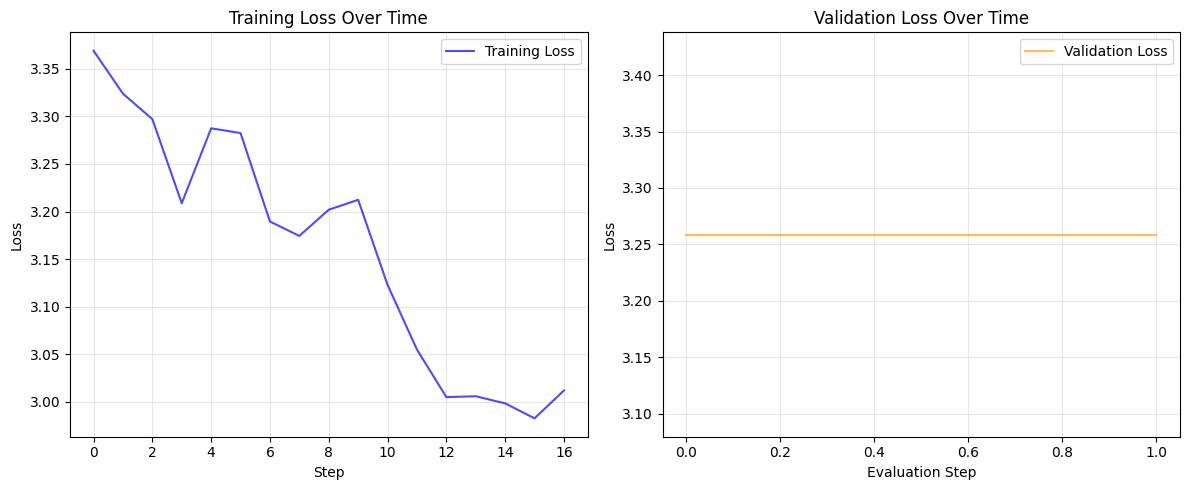


DIAGNOSIS

📈 Overfitting analysis:
  • Final training loss: 3.0121
  • Final validation loss: 3.2587
  • Gap: 0.2466
  ⚠️  Slight overfitting, but acceptable



In [ ]:
# ============================================
# TRAINING METRICS ANALYSIS
# ============================================

print("=" * 50)
print("TRAINING ANALYSIS")
print("=" * 50)

import numpy as np

# ============================================
# LOAD HISTORY FROM TRAINER
# ============================================

# The trainer saves all metrics during training
history = trainer.state.log_history

# Extract loss for training and validation
train_losses = [entry['loss'] for entry in history if 'loss' in entry]
eval_losses = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]

print(f"\n📊 Training statistics:")
print(f"  • Total training steps: {len(train_losses)}")
print(f"  • Evaluation steps: {len(eval_losses)}")

if train_losses:
    print(f"  • Initial loss: {train_losses[0]:.4f}")
    print(f"  • Final loss: {train_losses[-1]:.4f}")
    print(f"  • Improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")

if eval_losses:
    print(f"  • Best eval loss: {min(eval_losses):.4f}")
    print(f"  • Final eval loss: {eval_losses[-1]:.4f}")

# ============================================
# VISUALIZATION (requires matplotlib)
# ============================================

try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot evaluation loss
    if eval_losses:
        plt.subplot(1, 2, 2)
        plt.plot(eval_losses, label='Validation Loss', color='orange', alpha=0.7)
        plt.xlabel('Evaluation Step')
        plt.ylabel('Loss')
        plt.title('Validation Loss Over Time')
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('./training_metrics.png', dpi=150, bbox_inches='tight')
    print(f"\n✓ Chart saved at: ./training_metrics.png")
    plt.show()

except ImportError:
    print(f"\n⚠️  matplotlib not installed, skipping visualization")
    print(f"   Install with: pip install matplotlib")

# ============================================
# DIAGNOSIS
# ============================================

print(f"\n" + "=" * 50)
print("DIAGNOSIS")
print("=" * 50)

if train_losses and eval_losses:
    final_train_loss = train_losses[-1]
    final_eval_loss = eval_losses[-1]
    gap = final_eval_loss - final_train_loss

    print(f"\n📈 Overfitting analysis:")
    print(f"  • Final training loss: {final_train_loss:.4f}")
    print(f"  • Final validation loss: {final_eval_loss:.4f}")
    print(f"  • Gap: {gap:.4f}")

    if gap < 0.1:
        print(f"  ✅ Great! No significant overfitting")
    elif gap < 0.3:
        print(f"  ⚠️  Slight overfitting, but acceptable")
    else:
        print(f"  ❌ Overfitting! Consider:")
        print(f"     • Increase dropout")
        print(f"     • Reduce number of epochs")
        print(f"     • Increase dataset size")
        print(f"     • Reduce learning rate")

print("\n" + "=" * 50)